# **DAC training - Telco Customer Churn**


# Setup

In [1]:
# Standard
import pandas as pd
import numpy as np

# Plots
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import precision_recall_curve, auc, f1_score, plot_confusion_matrix, precision_score, recall_score


# Extras
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/chengtzuhsuan/.pyenv/versions/3.6.6/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Visualization Setup

In [2]:
# show percentage
def add_percentage(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 3
        y = p.get_y() + p.get_height() + total * 0.01
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    
# KDE plot
def kdeplot(feature):
    plt.figure(figsize=(6, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(data[data['Churn'] == 'No'][feature], label= 'Churn: No')
    ax1 = sns.kdeplot(data[data['Churn'] == 'Yes'][feature], label= 'Churn: Yes')
    
# Create a function to generate countplots:
plots = {1 : [111], 
         2: [121, 122], 
         3: [131, 132, 133], 
         4: [221, 222, 223, 224], 
         5: [231, 232, 233, 234, 235], 
         6: [231, 232, 233, 234, 235, 236]}

def countplot(x, y, df):
    
    rows = int(str(plots[len(y)][0])[0])
    columns = int(str(plots[len(y)][0])[1])
    
    plt.figure(figsize=(7*columns, 7*rows))
    
    for i, j in enumerate(y):
        plt.subplot(plots[len(y)][i])
        ax = sns.countplot(x=j, hue=x, data=df, alpha=0.8, linewidth=0.4)
        ax.set_title(j)
        
    return plt.show()

def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names']) # palette="Blues_d"
    plt.title(model_type + 'FEATURE IMPORTANCE')  
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return plt.show()

In [3]:
# Define a function that plots the feature weights for a classifier.
def feature_weights(X_df, classifier, classifier_name):
    weights = pd.Series(classifier.coef_[0], index=X_df.columns.values).sort_values(ascending=False)
    
    top_weights_selected = weights
    plt.figure(figsize=(10,7))
    plt.tick_params(labelsize=10)#plt.xlabel(fontsize=10)
    plt.title(f'{classifier_name} - Features')
    top_weights_selected.plot(kind="bar")
    
    return print("")

# Define a function that plots the confusion matrix for a classifier and the train and test accuracy
def confusion_matrix_plot(X_train, y_train, X_test, y_test, classifier, y_pred, classifier_name):
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(classifier, X_test, y_test, display_labels=["Not Churn", "Churn"], cmap=plt.cm.Blues, normalize=None, ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix')
    plt.show()
    
    print(f'Accuracy Score Test: {accuracy_score(y_test, y_pred)}')
    print(f'Accuracy Score Train: {classifier.score(X_train, y_train)} (as comparison)')
    return print("")

# Define a function that plots the ROC curve and the AUC score
def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
    
    y_pred_prob = y_pred_probabilities[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{classifier_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.show()
    
    return print(f'AUC Score (ROC): {roc_auc_score(y_test, y_pred_prob)}\n')

# Load Data
**Classification labels**

    - Churn - Whether the customer churned or not (Yes or No)

**Customer services booked**

    - PhoneService - Whether the customer has a phone service or not (Yes, No)
    - MultipleLines - Whether the customer has multiple lines or not (Yes, No, No phone service)
    - InternetService - Customer’s internet service provider (DSL, Fiber optic, No)
    - OnlineSecurity - Whether the customer has online security or not (Yes, No, No internet service)
    - OnlineBackup - Whether the customer has online backup or not (Yes, No, No internet service)
    - DeviceProtection - Whether the customer has device protection or not (Yes, No, No internet service)
    - TechSupport - Whether the customer has tech support or not (Yes, No, No internet service)
    - StreamingTV - Whether the customer has streaming TV or not (Yes, No, No internet service)
    - StreamingMovies - Whether the customer has streaming movies or not (Yes, No, No internet service)
    
**Customer account information**

    - Tenure - Number of months the customer has stayed with the company
    - Contract - The contract term of the customer (Month-to-month, One year, Two year)
    - PaperlessBilling - Whether the customer has paperless billing or not (Yes, No)
    - PaymentMethod - The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
    - MonthlyCharges - The amount charged to the customer monthly
    - TotalCharges - The total amount charged to the customer
    
**Customers demographic info**

    - customerID - Customer ID
    - Gender - Whether the customer is a male or a female
    - SeniorCitizen - Whether the customer is a senior citizen or not (1, 0)
    - Partner - Whether the customer has a partner or not (Yes, No)
    - Dependents - Whether the customer has dependents or not (Yes, No)

In [4]:
# when using colab
# !gdown --id 1QgNLcMqIj6tuIGXcAsWyxm4DTDtY-JZ3
data = pd.read_csv("Telco-Customer-Churn.csv")
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
print("Rows     : " ,data.shape[0])
print("Columns  : " ,data.shape[1])
print("\nFeatures : \n" ,data.columns.tolist())
print("\nMissing values :  ", data.isnull().sum().values.sum())
print("\nUnique values :  \n",data.nunique())
print("\nduplicate values :  \n",data.duplicated().sum())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

duplicate values :  
 0


In [42]:
data.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Number_AdditionalServices,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_12-24,tenure_group_24-48,tenure_group_48-60,tenure_group_gt_60
count,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000
mean,0.505,0.162,0.483,0.300,32.371,0.903,0.592,64.762,2279.734,0.265,2.038,0.097,0.422,0.440,0.217,0.217,0.287,0.217,0.345,0.217,0.344,0.217,0.290,0.217,0.384,0.217,0.388,0.209,0.241,0.216,0.336,0.229,0.145,0.226,0.118,0.200
std,0.500,0.369,0.500,0.458,24.559,0.296,0.491,30.090,2266.794,0.442,1.848,0.296,0.494,0.496,0.412,0.412,0.452,0.412,0.475,0.412,0.475,0.412,0.454,0.412,0.486,0.412,0.487,0.407,0.428,0.412,0.472,0.420,0.353,0.418,0.323,0.400
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.250,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,9.000,1.000,0.000,35.500,398.550,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,0.000,0.000,0.000,29.000,1.000,1.000,70.350,1394.550,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.000,1.000,1.000,55.000,1.000,1.000,89.850,3786.600,1.000,3.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
max,1.000,1.000,1.000,1.000,72.000,1.000,1.000,118.750,8684.800,1.000,6.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


# Data Cleaning before EDA

In [7]:
# Changing the data type of "TotalCharges" to float.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') # allow error
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [8]:
# check missing values again
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
# When TotalCharges is null, tenure is zero. So we decide to replace it by zero
data['TotalCharges'] = data['TotalCharges'].fillna(0).astype('float32')

# replace values
data["SeniorCitizen"] = data["SeniorCitizen"].replace({1:"Yes", 0:"No"})

# Separate churn and non churn customers
# churn     = data[data["Churn"] == "Yes"]
# not_churn = data[data["Churn"] == "No"]

# Hypothesis Building
Looking at the features included in data and connecting them to their potential influence on customer churn, the following hypotheses can be made:

- 合約期限越長，用戶愈不容易流失。

- 比起複雜度較高的合約組合，用戶比較容易取消簡單的合約。

- 有配偶或小孩的用戶較不會流失。

- 一般我們認為 用戶已使用期間(Tenure)、合約種類(contract)、附加服務數量是影響用戶流失的重要特徵。

- 愈貴的合約方案，顧客流失的機率愈高，顧客容易被其他電信資費低的方案吸引。

- 由於終止合約有轉換成本，因此老年人的流失率會較低。

# EDA

## Target Variable
> - The data is imbalanced.

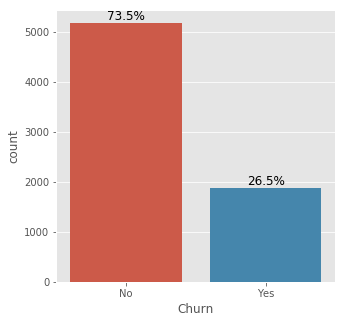

In [10]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x = "Churn", data = data)
add_percentage(ax, data.Churn)

## Features

### Numerical Variables

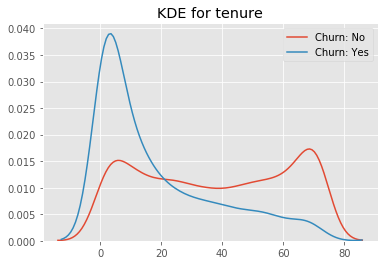

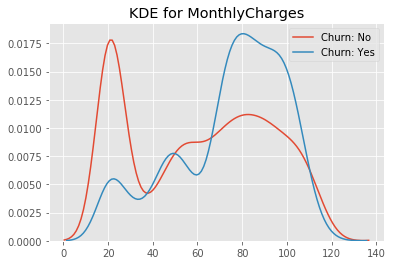

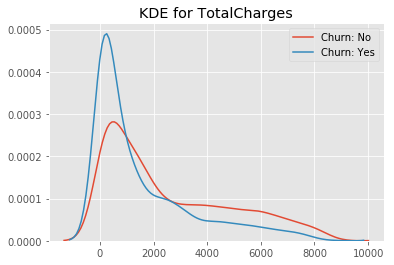

In [11]:
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

**Insights**
>- 使用時間(tenure)越少的用戶更容易流失。
>- 每月收取金額(MonthlyCharges)越高的用戶更容易流失。

In [12]:
# simple clustering of tenure
def tenure_lab(x) : 
    if x <= 12 :
        return "0-12"
    elif (x > 12) & (x <= 24 ):
        return "12-24"
    elif (x > 24) & (x <= 48) :
        return "24-48"
    elif (x > 48) & (x<= 60) :
        return "48-60"
    elif x > 60 :
        return "gt_60"
    
data['tenure_group'] = data['tenure'].apply(tenure_lab)

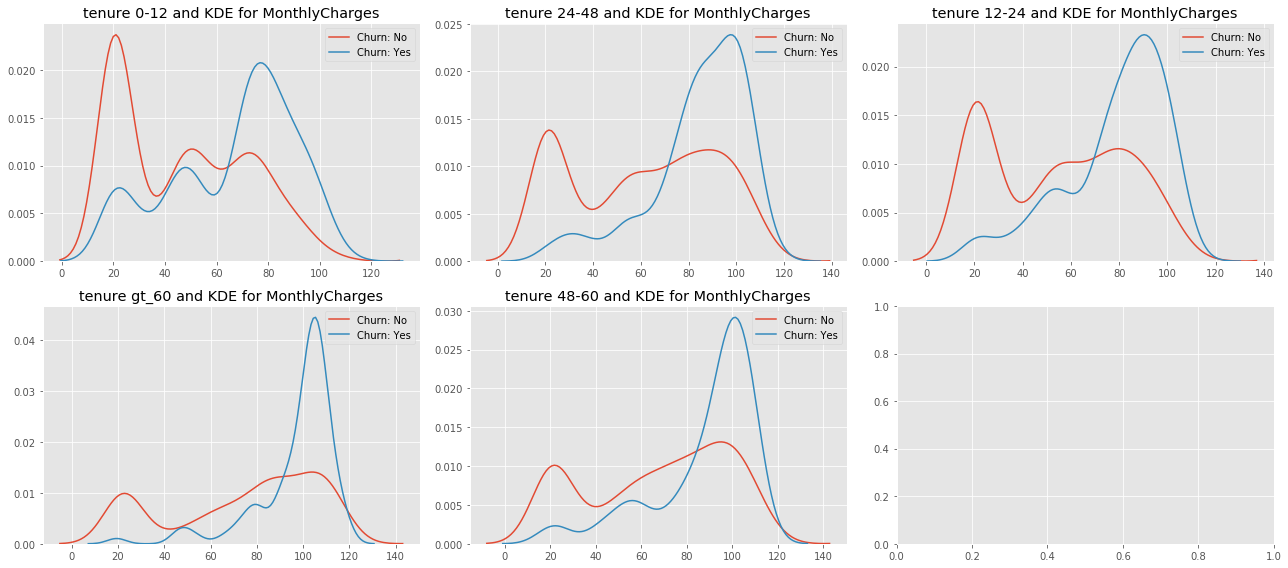

In [14]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 8))
for n,i  in enumerate(data['tenure_group'].unique()):
    df = data[data['tenure_group']==i]
    if n <3 :
        p = 0
    else :
        p = 1
        n-=3
    ax =sns.kdeplot(df[df['Churn'] == 'No']['MonthlyCharges'], label= 'Churn: No',ax=axis[p][n])
    ax =sns.kdeplot(df[df['Churn'] == 'Yes']['MonthlyCharges'], label= 'Churn: Yes',ax=axis[p][n])
    ax.set_title("tenure {} and KDE for MonthlyCharges".format(i))
    plt.tight_layout()

>- 無論往來期間如何，月租費越高流失率就越高，以往來期間 4 年以上的客戶最明顯。

### Categorical Variables

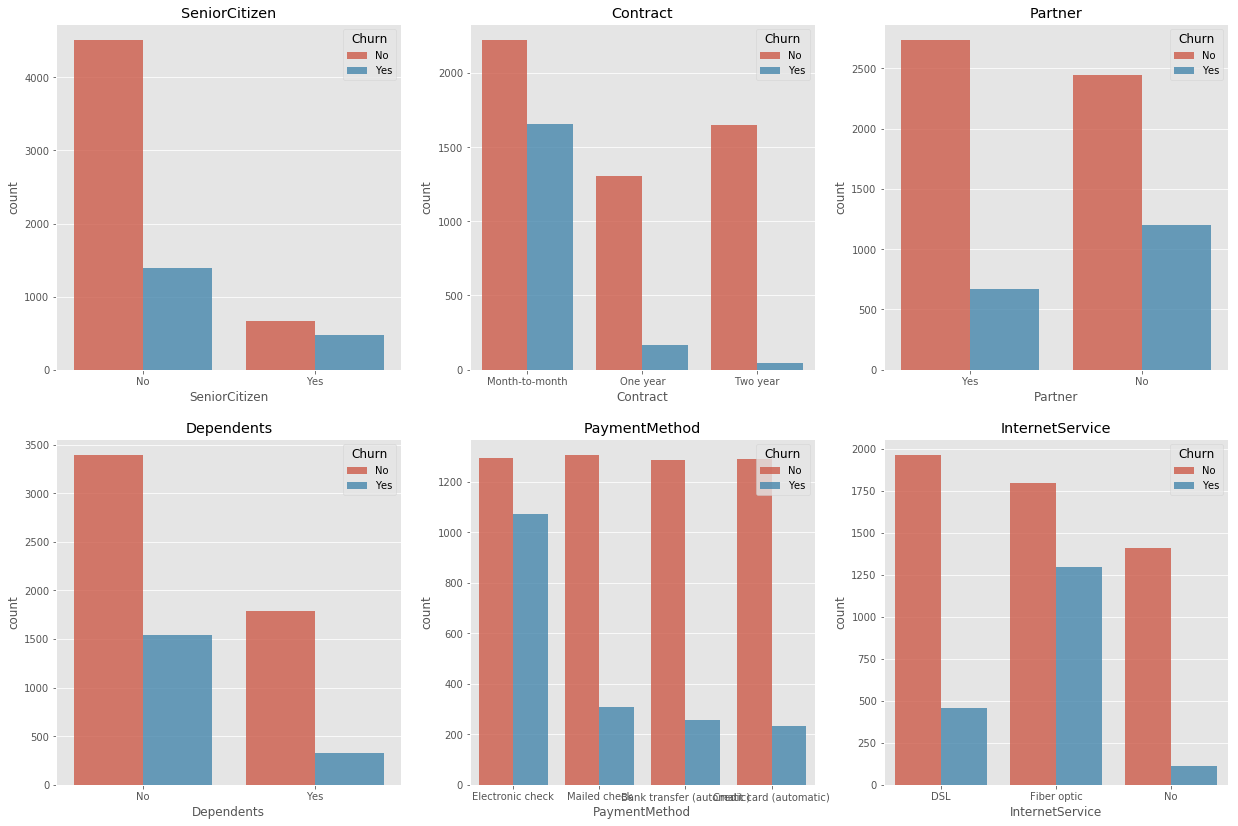

In [15]:
# Generate countplots for various features.
countplot("Churn", 
          ['SeniorCitizen', 'Contract', 'Partner', 'Dependents', 'PaymentMethod', 'InternetService'], 
          data)

**Insights**
>- 老年客戶(SeniorCitizen)有較高的流失率。
>- 按月合約(Contract)的客戶有較高的流失率。
>- 沒有夥伴(Partner)或沒有家屬(Dependents)的客戶有較高的流失率。
>- 使用電子支票支付(PaymentMethod)的客戶有較高的流失率。
>- 客戶的網路提供商(InternetService)為Fiber時有較高的流失率。

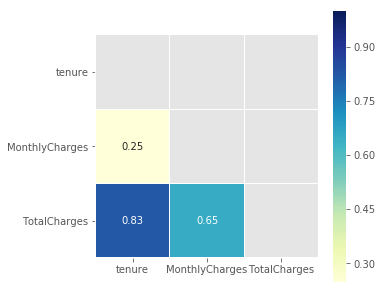

In [16]:
plt.figure(figsize=(5, 5))
corr = data.drop(columns = ['customerID']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, xticklabels=corr.columns,mask=mask, yticklabels=corr.columns, square=True,
                  linewidths=.2, cmap="YlGnBu",annot=True)

總收取費用(TotalCharges) 與使用時間(tenure)具高度線性相關是很合理的結果，這邊先保留兩者原始資訊。

# Data Preprocessing

In [17]:
# drop useless columns
data.drop(columns=['customerID'], inplace=True)

In [18]:
# Generate new feature "Number_AdditionalServices" by summing up the number of add-on services consumed.
data['Number_AdditionalServices'] = (data[['OnlineSecurity', 
                                       'DeviceProtection', 
                                       'StreamingMovies', 
                                       'TechSupport', 'StreamingTV', 'OnlineBackup']] == 'Yes').sum(axis=1)

data2 = data.copy() # for tree-based model

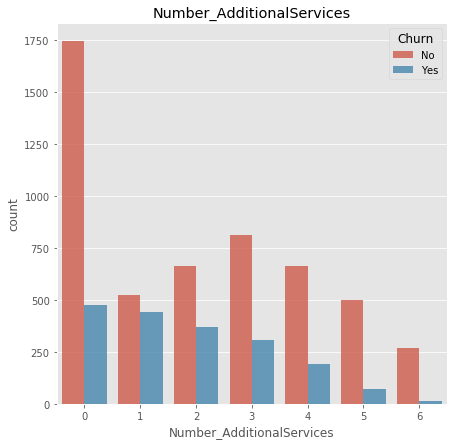

In [19]:
# Generate countplot for the new feature.
countplot('Churn', ['Number_AdditionalServices'], data)

In [20]:
# target variable
target_col = ["Churn"]

# categorical variables
cat_cols = data.nunique()[data.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]

# numerical variables
num_cols = [x for x in data.columns if x not in cat_cols + target_col ]

# binary variables
# gender 0=female, 1=male
bin_cols = data.nunique()[data.nunique() == 2].keys().tolist()

# multi label variables
multi_cols = [i for i in cat_cols if i not in bin_cols]

# encoding for binary varibales
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
# create dummy variables, drop 1 = true
data = pd.get_dummies(data = data, columns = multi_cols, drop_first = True)

In [21]:
print("\nnum_cols\n", num_cols)
print("\ncat_cols\n", cat_cols)
print("bin_cols\n", bin_cols)
print("\nmulti_cols\n", multi_cols)


num_cols
 ['tenure', 'MonthlyCharges', 'TotalCharges', 'Number_AdditionalServices']

cat_cols
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']
bin_cols
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

multi_cols
 ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'tenure_group']


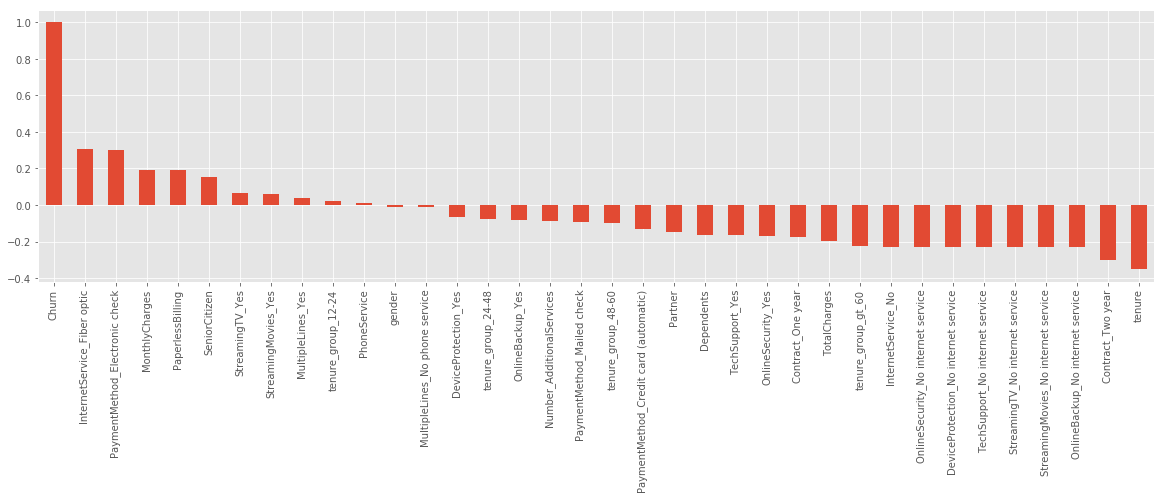

In [22]:
# Show correlation plot for correlation of Churn with each of the remaining features.
plt.figure(figsize=(16,10))
data.corr()['Churn'].sort_values(ascending=False).plot(kind='bar', figsize=(20,5))

# Train-Test-Split

In [23]:
X = data.drop('Churn', axis=1)
#X = X1.values
y = data['Churn'].values

X_train_lr, X_test_lr, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
scaler = StandardScaler()
scaler.fit(X_train_lr[num_cols])
X_train_lr[num_cols] = scaler.transform(X_train_lr[num_cols])
X_test_lr[num_cols] = scaler.transform(X_test_lr[num_cols])

In [25]:
X_train_lr.shape

(5634, 35)

In [26]:
X_test_lr.shape

(1409, 35)

# Model Selection, Training, Prediction and Assessment

- Logistic Regression - fast and linear model
- Random Forest - slower but accurate ensemble model based on decision trees

## Logistic Regression (Baseline)

In [27]:
# modeling
logit = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
logit.fit(X_train_lr, y_train)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred_logit = logit.predict(X_test_lr)
y_pred_logit_prob = logit.predict_proba(X_test_lr)

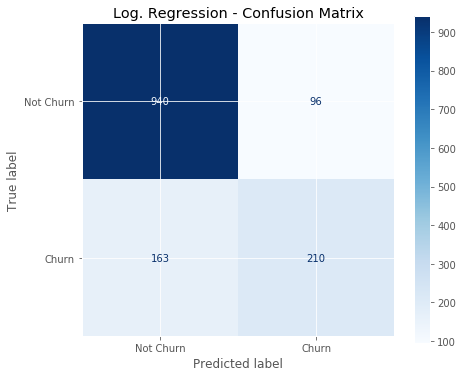

Accuracy Score Test: 0.8161816891412349
Accuracy Score Train: 0.80386936457224 (as comparison)



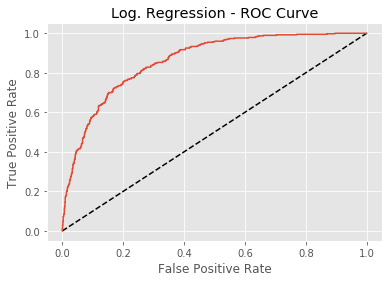

AUC Score (ROC): 0.8603737306820417

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.56      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409




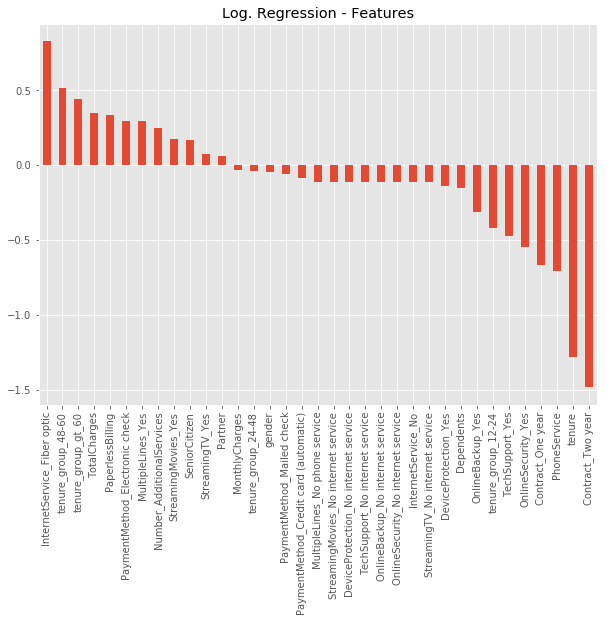

In [28]:
# Plot model evaluations.
confusion_matrix_plot(X_train_lr, y_train, X_test_lr, y_test, logit, y_pred_logit, 'Log. Regression')
roc_curve_auc_score(X_test_lr, y_test, y_pred_logit_prob, 'Log. Regression')
print(classification_report(y_test, y_pred_logit))
feature_weights(X_train_lr, logit, 'Log. Regression')

## SMOTE (Synthetic Minority Oversampling Technique)
對於前述提到不平衡目標變數問題，採 SMOTE 方式(利用已有樣本生成更多樣本)處理:

- 隨機選擇少數類樣本的一點
- 以歐氏距離計算它到少數類樣本集中所有樣本的距離，得到 k 個近鄰
- 對每個最近鄰到目標樣本間乘以 0~1 之間的一個比例，增加到樣本內

In [29]:
from imblearn.over_sampling import SMOTE

#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2 ,random_state = 42)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
X_os_smote, y_os_smote = os.fit_sample(X_train, y_train)

cols = X.columns
X_os_smote = pd.DataFrame(data = X_os_smote, columns=cols)
y_os_smote = pd.DataFrame(data = y_os_smote, columns=target_col)

X_os_smote[num_cols] = scaler.transform(X_os_smote[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [30]:
logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

logit_smote.fit(X_os_smote, y_os_smote)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred_logit_smote = logit_smote.predict(X_test)
y_pred_logit_smote_prob = logit_smote.predict_proba(X_test)

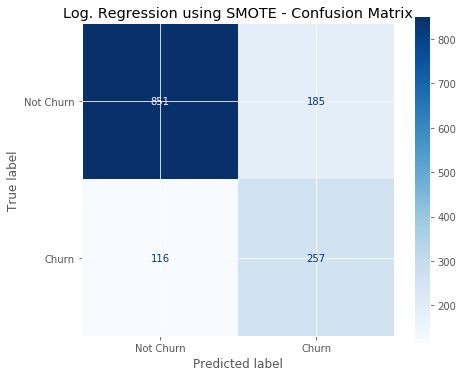

Accuracy Score Test: 0.7863733144073811
Accuracy Score Train: 0.8295070082165297 (as comparison)



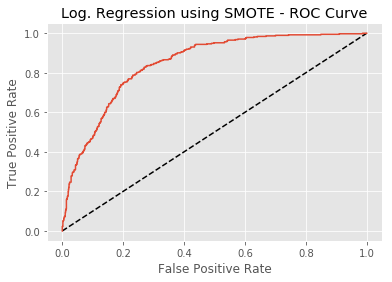

AUC Score (ROC): 0.8474579999378927

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1036
           1       0.58      0.69      0.63       373

    accuracy                           0.79      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.79      0.79      1409



In [31]:
# Plot model evaluations.
confusion_matrix_plot(X_os_smote, y_os_smote, X_test, y_test, logit_smote, y_pred_logit_smote, 'Log. Regression using SMOTE')
roc_curve_auc_score(X_test, y_test, y_pred_logit_smote_prob, 'Log. Regression using SMOTE')
print(classification_report(y_test, y_pred_logit_smote))

## Decision Tree

In [32]:
le = LabelEncoder()
for i in cat_cols :
    data2[i] = le.fit_transform(data2[i])
    
data2['Churn'] = le.fit_transform(data2['Churn'])

In [33]:
X = data2.drop('Churn', axis=1)
#X = X1.values
y = data2['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

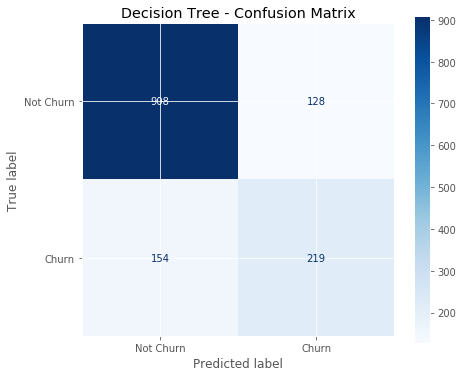

Accuracy Score Test: 0.7998580553584103
Accuracy Score Train: 0.8091941782037628 (as comparison)



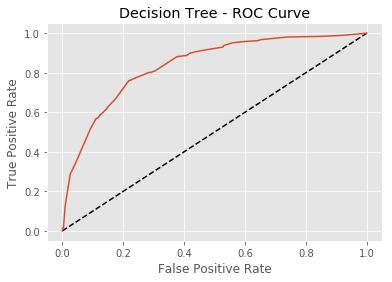

AUC Score (ROC): 0.8377899634602046

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1036
           1       0.63      0.59      0.61       373

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



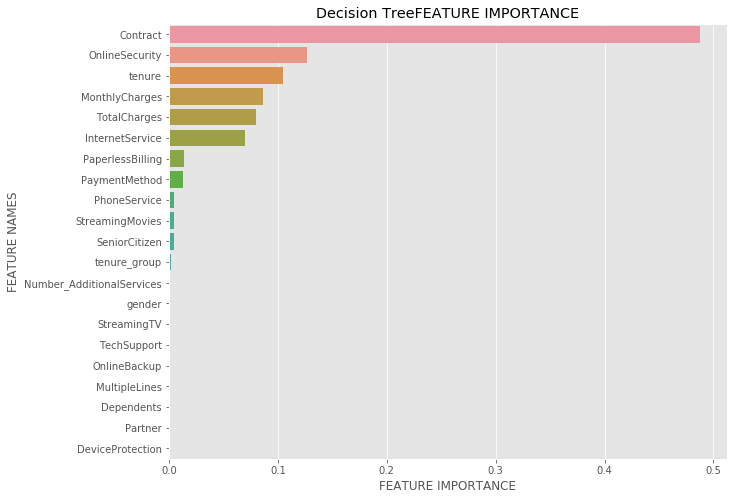

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred_dt = dt.predict(X_test)
y_pred_dt_prob = dt.predict_proba(X_test)

# Evaluation
confusion_matrix_plot(X_train, y_train, X_test, y_test, dt, y_pred_dt, 'Decision Tree')
roc_curve_auc_score(X_test, y_test, y_pred_dt_prob, 'Decision Tree')
print(classification_report(y_test, y_pred_dt))
plot_feature_importance(dt.feature_importances_, X_train.columns,'Decision Tree')

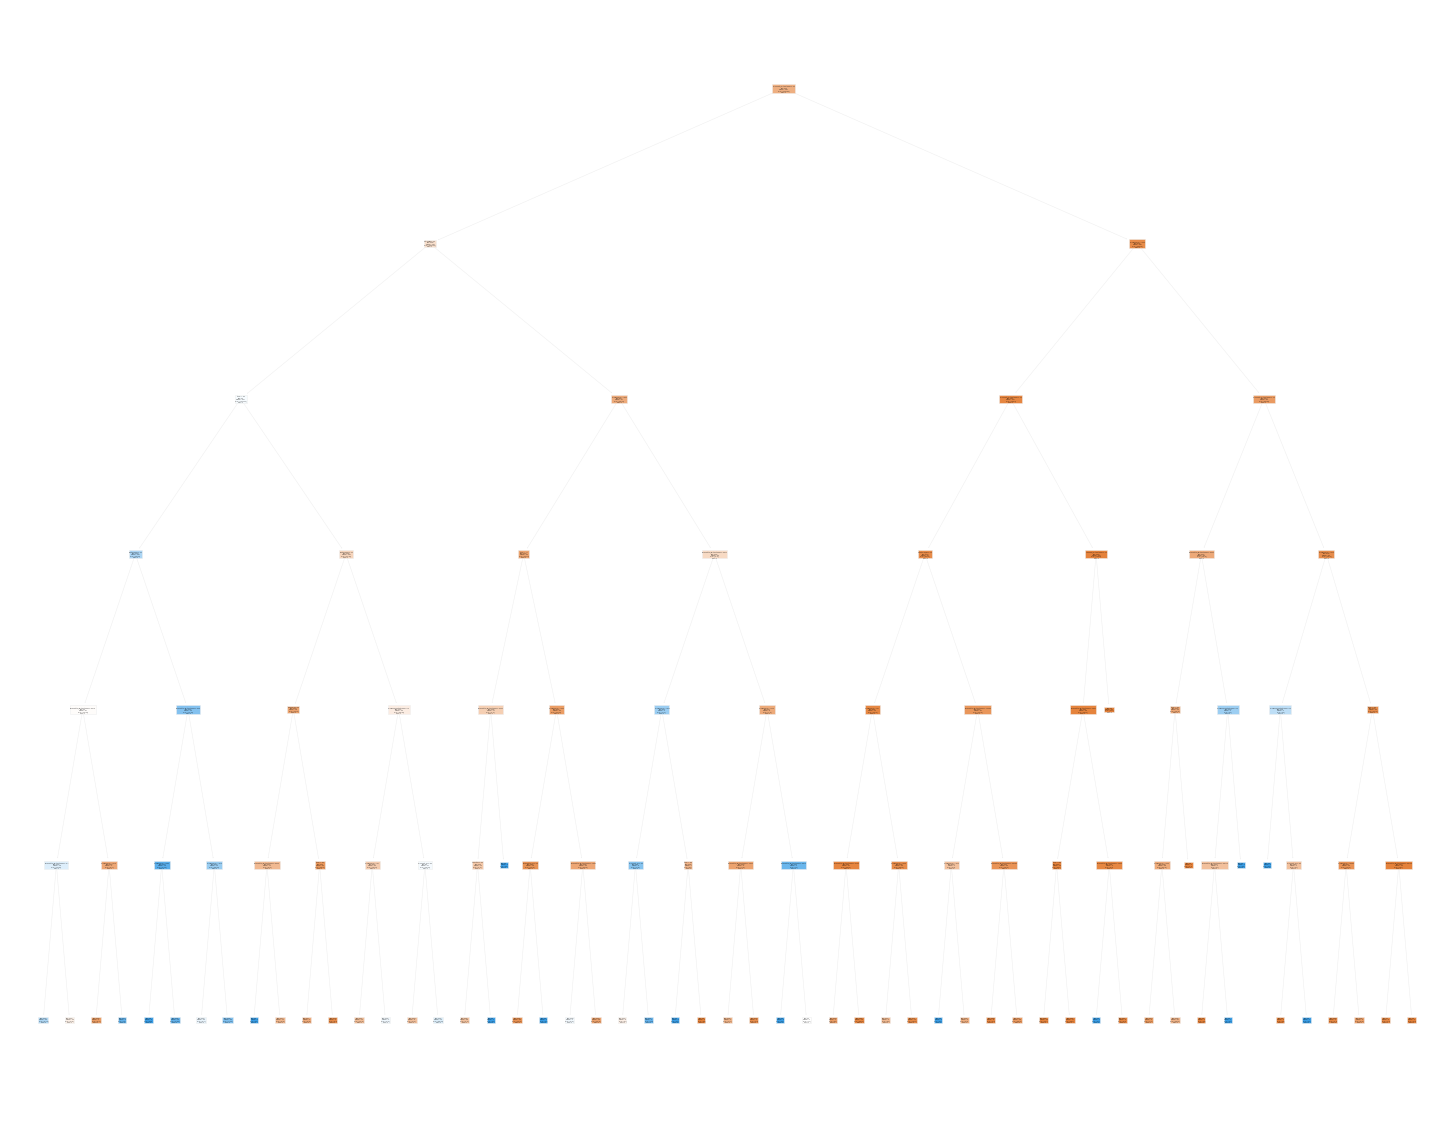

In [35]:
#If you want to plot tree 
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=X_train_lr.columns,  
                   class_names='Churn',
                   filled=True)

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200,
                            max_features = 1,
                            max_depth = 6,
                            random_state = 0)
rf.fit(X_train, y_train)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob = rf.predict_proba(X_test)

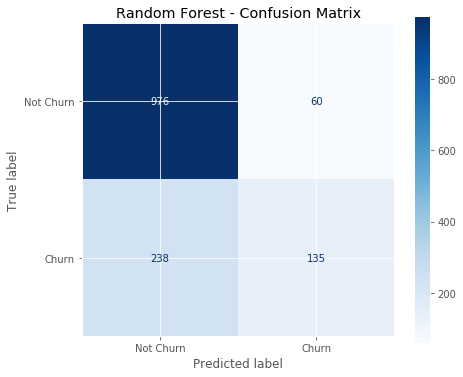

Accuracy Score Test: 0.7885024840312278
Accuracy Score Train: 0.8004969826056088 (as comparison)



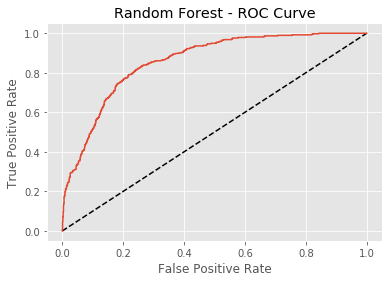

AUC Score (ROC): 0.8570600474085729

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1036
           1       0.69      0.36      0.48       373

    accuracy                           0.79      1409
   macro avg       0.75      0.65      0.67      1409
weighted avg       0.77      0.79      0.76      1409



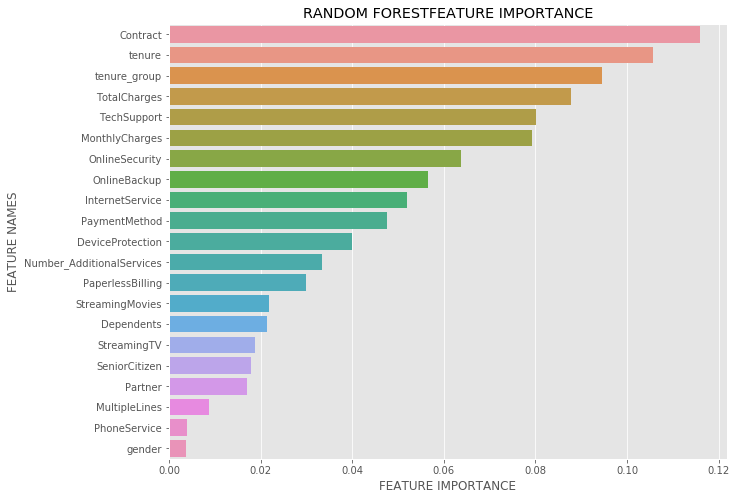

In [37]:
confusion_matrix_plot(X_train, y_train, X_test, y_test, rf, y_pred_rf, 'Random Forest')
roc_curve_auc_score(X_test, y_test, y_pred_rf_prob, 'Random Forest')
print(classification_report(y_test, y_pred_rf))
plot_feature_importance(rf.feature_importances_, X_train.columns,'RANDOM FOREST')

> Feature Importance: 影響流失的前五特徵為:
> - 1. 合約種類
> - 2. 使用期間
> - 3. 總花費
> - 4. 是否有技術支援
> - 5. 是否有在線安全服務

## XGboost

[12:00:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:00:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


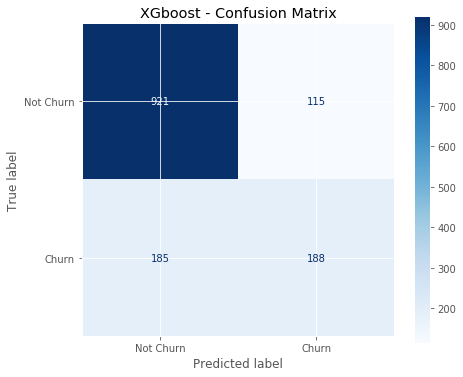

Accuracy Score Test: 0.78708303761533
Accuracy Score Train: 0.9817181398651047 (as comparison)



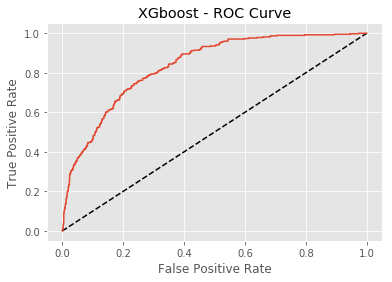

AUC Score (ROC): 0.8350533605225294

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.62      0.50      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



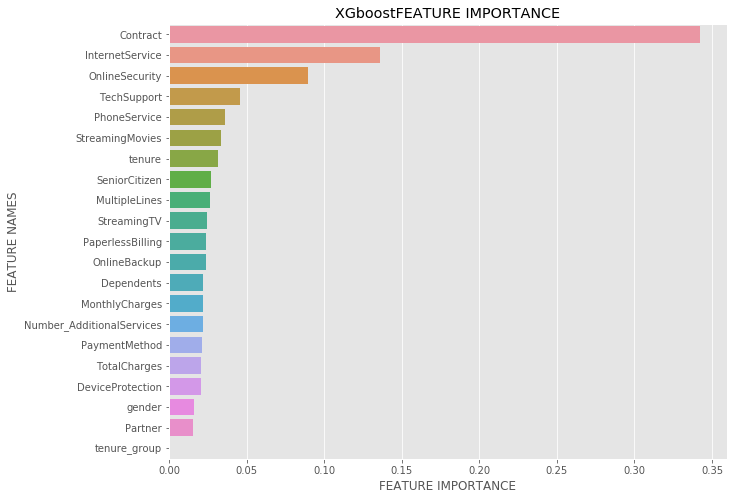

In [38]:
from xgboost import XGBClassifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=1000,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)


xgb.fit(X_train, y_train)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_prob = xgb.predict_proba(X_test)

# Evaluation
confusion_matrix_plot(X_train, y_train, X_test, y_test, xgb, y_pred_xgb, 'XGboost')
roc_curve_auc_score(X_test, y_test, y_pred_xgb_prob, 'XGboost')
print(classification_report(y_test, y_pred_xgb))
plot_feature_importance(xgb.feature_importances_, X_train.columns,'XGboost')

## GBDT

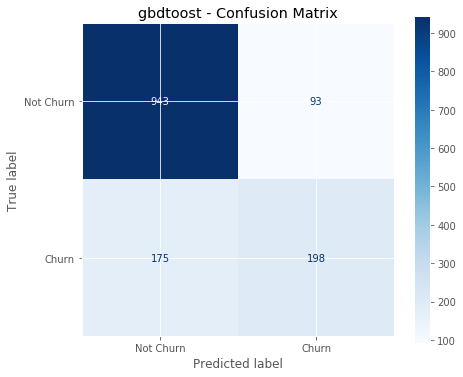

Accuracy Score Test: 0.8097941802696949
Accuracy Score Train: 0.8141640042598509 (as comparison)



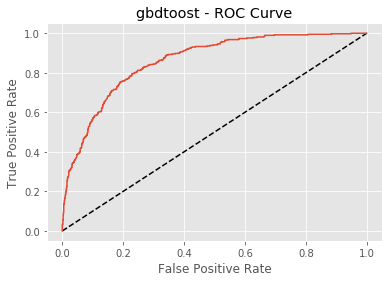

AUC Score (ROC): 0.8591574627097415

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.68      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



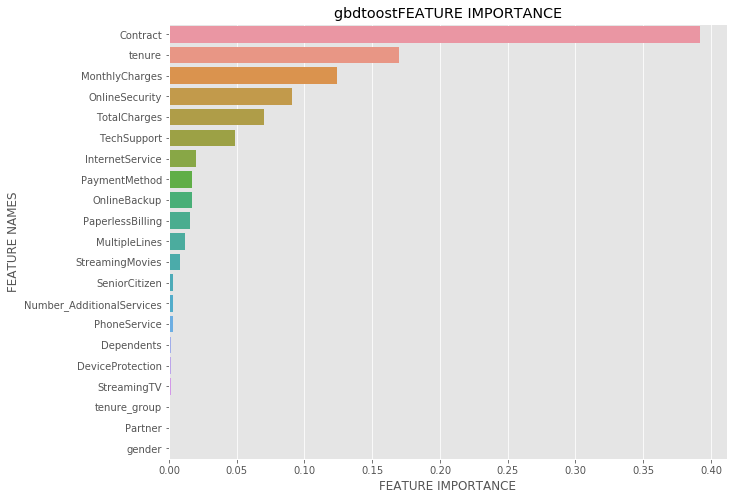

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(n_estimators = 300, 
                                     subsample = 0.7,
                                    n_iter_no_change = 10,
                                     random_state = 0)

gbdt.fit(X_train, y_train)

# Make predictions (classes and probabilities) with the trained model on the test set.
y_pred_gbdt = gbdt.predict(X_test)
y_pred_gbdt_prob = gbdt.predict_proba(X_test)

#Evaluation
confusion_matrix_plot(X_train, y_train, X_test, y_test, gbdt, y_pred_gbdt, 'gbdtoost')
roc_curve_auc_score(X_test, y_test, y_pred_gbdt_prob, 'gbdtoost')
print(classification_report(y_test, y_pred_gbdt))
plot_feature_importance(gbdt.feature_importances_, X_train.columns,'gbdtoost')

# (Skip) Hyperparameter Tuning/Model Improvement
no time to cover this part XD

In [40]:
# from sklearn.model_selection import RandomizedSearchCV

# #Define parameter grid for RandomizedSearch and instanciate and train model.
# param_grid_rf = {'n_estimators': np.arange(10, 2000, 10), 
#                  'max_features': ['auto', 'sqrt'],
#                  'max_depth': np.arange(10, 200, 10),
#                  'criterion': ['gini', 'entropy'],
#                  'bootstrap': [True, False]}

# rf = RandomForestClassifier()
# rf_random_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=5, verbose=0)
# rf_random_grid.fit(X_train, y_train)

# # Make predictions (classes and probabilities) with the trained model on the test set.
# y_pred_rf_tuned = rf_random_grid.predict(X_test)
# y_pred_rf_tuned_prob = rf_random_grid.predict_proba(X_test)

# print('Random Forest - Best Parameters: ', rf_random_grid.best_params_)

In [41]:
# confusion_matrix_plot(X_train, y_train, X_test, y_test, rf_random_grid, y_pred_rf_tuned, 'Random Forest (Tuned)')
# roc_curve_auc_score(X_test, y_test, y_pred_rf_tuned_prob, 'Random Forest (Tuned)')
# print(classification_report(y_test, y_pred_rf_tuned))

# Summary

## Model Summary

- Overall The Best Performance: Logistic Regression (Baseline)
    - Accuracy: 0.81
    - AUC: 0.86
    - **Hit Ratio** (Precision): 0.69
    - Recall: 0.56
    
    
- The Best Recall: Logistic Regression (SMOTE) 0.69 --> 實際流失的顧客，有多少比例被我們預測到？


- The Best Precision: Logistic, RF 0.69 --> 預測為流失的顧客，有多少比例是真的流失的？


- Overfitting Problem: XGBoost


- Feature Importance: 影響流失的前五特徵為:
> 1. 合約種類
> 2. 使用期間
> 3. 總花費
> 4. 是否有技術支援
> 5. 是否有在線安全服務

## Hypotheses Check

- 合約期限越長，用戶愈不容易流失 
> Accepted! Contract 是重要的特徵之一，其中Month-to-Month流失率最大

- 比起複雜度較高的合約組合，用戶比較容易取消簡單的合約 
> Partially Accepted! 特徵重要程度大概在中間，EDA結果支持

- 有配偶或小孩的用戶較不會流失。 
> Reject! 特徵重要度低

- 一般我們認為 用戶已使用期間(Tenure)、合約種類(contract)、附加服務數量是影響用戶流失的重要特徵。
> 用戶已使用時間、合約種類是重要特徵

- 愈貴的合約方案，顧客流失的機率愈高，顧客容易被其他電信資費低的方案吸引。
> Partially Accepted! 月費是有間接的影響，但比起月費，用戶的使用期間更影響其留存

- 由於終止合約有轉換成本，因此老年人的流失率會較低。
> Reject! 此項特徵沒有太高的權重，此外從EDA, 可以看出老人的流失率比起非老人高。

## Future Work

- Analyze the relation between monthly charges and all add-on services